In [78]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import sqlite3 as lite
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline

In [79]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.124 Safari/537.36'}

In [80]:
cities = [['tx', "austin"] ,[ 'ca' , 'los-angeles'] ,[ 'ga' , 'atlanta'] ,[ 'ma' , 'boston'] ,[ 'nc' , 'charlotte'] ,[ 'tx' , 'dallas'] ,[ 'co' , 'denver'] ,[ 'tx' , 'houston'] ,[ 'fl' , 'miami'] ,[ 'mn' , 'minneapolis'] ,[ 'ny' , 'new-york'] ,[ 'pa' , 'philadelphia'] ,[ 'az' , 'phoenix'] ,[ 'or' , 'portland'] ,[ 'ca' , 'san-francisco'] ,[ 'ca' , 'san-diego'] ,[ 'wa' , 'seattle'] ,[ 'dc' , 'washington'] ]

In [81]:
# CRAWL ALL THE PAGES OF INTERST
datadir = 'crawl/'
if not(os.path.isdir(datadir)):
    os.makedirs(datadir)

for city in cities:
    k = city[0]
    v = city[1]
    running = True
    page = 1
    print ''
    print k,v
    while running:
        url = "https://dogvacay.com/dog-boarding--" + k + "--" + v + "?p="+str(page)
        filename = datadir + k + '-' + v + '-' + str(page) + '.htm'
        if not(os.path.isfile(filename)):
            sys.stdout.write('-')
            r = requests.get(url, headers=headers)
            time.sleep(1)
            f = open(filename, 'w')
            f.write(r.text.encode('ascii', 'replace'))
            f.close()
            data = r.text
        else:
            sys.stdout.write('.')
            f = open(filename, 'r')
            data = f.read()
            f.close()
        soup = BeautifulSoup(data)
        pagination_links = soup.findAll('a', {'class': 'pagination-link'})
        running = False
        for pl in pagination_links:
            if pl.text.find('Next') == 0:
                running = True
        page+=1



tx austin
.........
ca los-angeles
........................................................
ga atlanta
............
ma boston
.............
nc charlotte
.......
tx dallas
............
co denver
...........
tx houston
...........
fl miami
.........
mn minneapolis
.......
ny new-york
...............................................................
pa philadelphia
............
az phoenix
.........
or portland
..........
ca san-francisco
.............................
ca san-diego
............
wa seattle
..........
dc washington
...........................

In [82]:
# Data extraction phase

times = []
fees = []
reviews = []
repeats = []
city = []
service = []
rating = []



for src in os.listdir(datadir):
    filename = datadir + src
    print 'Processing: ' + filename
    f = open(filename, 'r')
    data = f.read()
    f.close()
    soup = BeautifulSoup(data)
    sitters = soup.findAll('div', {'class': 'card-content'})
    for sitter in sitters:
        rtwrap = sitter.findAll('div', {'class': 'icon-wrapper'})
        if len(rtwrap) > 0:
            response_time = rtwrap[0].text.strip('\n')[19:]
        else:
            response_time = -1
        fee = sitter.findAll('div', {'class': 'price price--primary u-text-center'})
        review = sitter.find('span', {'class': 'vcard-review'})
        if review is not None and len(review) > 0:
            review = int(review.text.replace('Reviews', '').replace('Review', '').strip())
        else:
            review = 0
        repeat = sitter.findAll('div', {'class': 'icon-wrapper'})
        if len(repeat) == 2 and len(repeat[1].text.strip()) > 12:
            repeat = repeat[1].text.strip()[:2]
        else:
            repeat = 0
        services = sitter.findAll('div', {'class': 'vcard-line-item'})
        full_star = sitter.findAll('i', {'class': 'ck-star'})
        ratings = len(full_star)
        half_star = sitter.findAll('i', {'class': 'ck-star-half'})
        if len(half_star) > 0:
            ratings += .5
        fees.append(fee[0].text.strip('\n$')[:2])
        title = soup.find('title').text
        i = title.find(' Dog Boarding')
        title = title[0:i]
        city.append(title)
        times.append(response_time)
        reviews.append(review)
        repeats.append(repeat)
        service.append(services[-1].text.strip('\n'))
        rating.append(ratings)

df = pd.DataFrame({'city': city, 'fee': fees, 'response_time': times, 'review' : reviews, 'repeat' : repeats, 'services' : service, 'ratings': rating})

Processing: crawl/az-phoenix-1.htm
Processing: crawl/az-phoenix-2.htm
Processing: crawl/az-phoenix-3.htm
Processing: crawl/az-phoenix-4.htm
Processing: crawl/az-phoenix-5.htm
Processing: crawl/az-phoenix-6.htm
Processing: crawl/az-phoenix-7.htm
Processing: crawl/az-phoenix-8.htm
Processing: crawl/az-phoenix-9.htm
Processing: crawl/ca-los-angeles-1.htm
Processing: crawl/ca-los-angeles-10.htm
Processing: crawl/ca-los-angeles-11.htm
Processing: crawl/ca-los-angeles-12.htm
Processing: crawl/ca-los-angeles-13.htm
Processing: crawl/ca-los-angeles-14.htm
Processing: crawl/ca-los-angeles-15.htm
Processing: crawl/ca-los-angeles-16.htm
Processing: crawl/ca-los-angeles-17.htm
Processing: crawl/ca-los-angeles-18.htm
Processing: crawl/ca-los-angeles-19.htm
Processing: crawl/ca-los-angeles-2.htm
Processing: crawl/ca-los-angeles-20.htm
Processing: crawl/ca-los-angeles-21.htm
Processing: crawl/ca-los-angeles-22.htm
Processing: crawl/ca-los-angeles-23.htm
Processing: crawl/ca-los-angeles-24.htm
Process

In [84]:
df.shape

(4662, 7)

In [85]:
df.head()

,city,fee,ratings,repeat,response_time,review,services
0,"Phoenix, Arizona",35,5,8,Few Hours,26,Boarding and Daycare
1,"Phoenix, Arizona",35,5,16,Day,30,"Boarding, Checkups and Visits, and Pick up and..."
2,"Phoenix, Arizona",35,0,0,Few Hours,0,"Boarding, Daycare, Checkups and Visits, Walkin..."
3,"Phoenix, Arizona",38,5,2,Few Days,3,"Boarding, Daycare, Checkups and Visits, Walkin..."
4,"Phoenix, Arizona",25,5,1,Few Hours,5,"Boarding, Checkups and Visits, Walking, and Ba..."


In [86]:
#eliminate trailing spaces from response_time
df['response_time'] = df['response_time'].apply(lambda x: str(x).strip())

In [87]:
#separate services
df['boarding'] = df['services'].map(lambda x: 1 if "Boarding" in x else 0)
df['sitting'] = df['services'].map(lambda x: 1 if "Sitting" in x else 0)
df['daycare'] = df['services'].map(lambda x: 1 if "Daycare" in x else 0)
df['checkups'] = df['services'].map(lambda x: 1 if "Checkups and Visits" in x else 0)
df['walking'] = df['services'].map(lambda x: 1 if "Walking" in x else 0)
df['bathing'] = df['services'].map(lambda x: 1 if "Bathing" in x else 0)
df['training'] = df['services'].map(lambda x: 1 if "Training" in x else 0)
df['grooming'] = df['services'].map(lambda x: 1 if "Grooming" in x else 0)
df['pickup/dropoff'] = df['services'].map(lambda x: 1 if "Pick up and Drop off" in x else 0)

In [88]:
# drop services column
df.drop(['services'], axis=1, inplace=True)

In [89]:
#response time
df['response_time'] = df['response_time'].map(lambda x: 1 if x == 'Few Hours' else 2 if x == 'Day' else 3)

In [90]:
df.ix[df['fee']=='', 'fee'] = 0

In [91]:
df["fee"] = df["fee"].astype(float)
df["repeat"] = df["repeat"].astype(int)

In [92]:
df['services'] = df['boarding']+df['sitting']+df['daycare']+df['checkups']+df['walking']+df['bathing']+df['training']+df['grooming']+df['pickup/dropoff']

In [113]:
# SAVE TO CSV FILE

df.to_csv('dog-vacay.csv', sep='\t')

In [93]:
df.head()

,city,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services
0,"Phoenix, Arizona",35,5,8,1,26,1,0,1,0,0,0,0,0,0,2
1,"Phoenix, Arizona",35,5,16,2,30,1,0,0,1,0,0,0,0,1,3
2,"Phoenix, Arizona",35,0,0,1,0,1,0,1,1,1,0,0,0,0,4
3,"Phoenix, Arizona",38,5,2,3,3,1,0,1,1,1,0,0,0,0,4
4,"Phoenix, Arizona",25,5,1,1,5,1,0,0,1,1,1,0,0,0,4


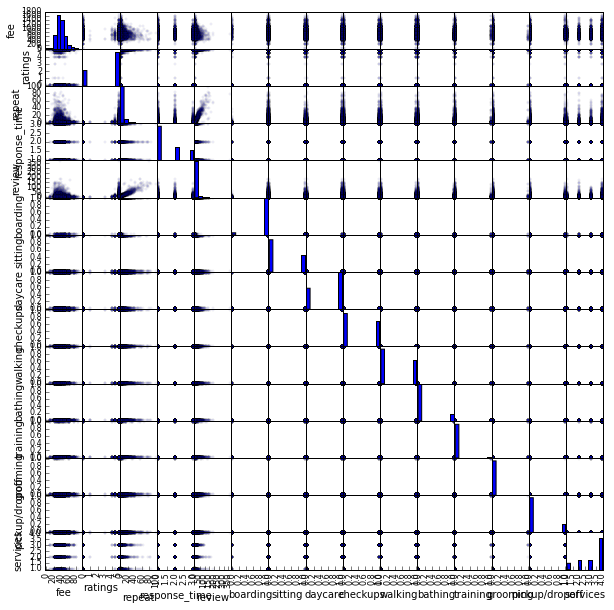

In [94]:
#Create a scatter plot matrix
a = pd.scatter_matrix(df, alpha=.05, figsize=(10,10))
plt.show()

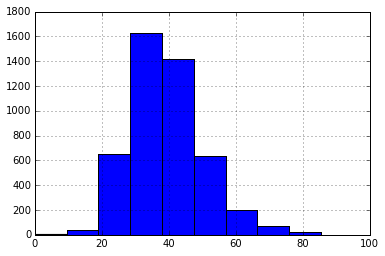

In [25]:
#Histogram of fees
p = df['fee'].hist()
plt.show()

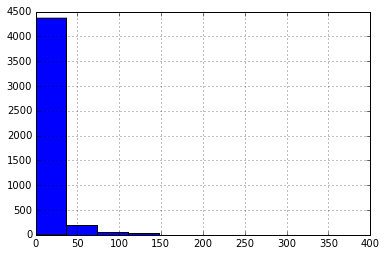

In [103]:
p = df['review'].hist()
plt.show()

In [95]:
df.groupby('city').sum()

,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services
city,,,,,,,,,,,,,,,
"Atlanta, Georgia",5509,702.5,1073,278,2317,171,63,128,84,58,29,6,2,33,574
"Austin, Texas",4009,441.0,587,189,1234,111,50,67,60,54,21,4,2,35,404
"Boston, Massachusetts",7573,774.5,997,300,1953,185,48,109,70,66,23,2,0,43,546
"Charlotte, North Carolina",2931,383.5,614,163,1089,93,38,72,49,35,13,5,1,7,313
"Dallas, Texas",5396,564.0,1081,266,2217,154,64,112,78,72,32,9,5,33,559
"Denver, Colorado",5059,615.5,1143,264,2073,162,46,114,57,52,13,0,1,40,485
"Houston, Texas",4932,556.0,1039,216,2167,153,42,107,82,42,35,5,5,23,494
"Los Angeles, California",34363,2537.0,3788,1302,8246,701,425,545,432,378,116,30,11,164,2802
"Miami, Florida",4616,437.5,482,215,1132,134,43,97,63,65,34,7,0,23,466


In [96]:
sea = df[df.city == 'Seattle, Washington']
atx = df[df.city == 'Austin, Texas']

In [97]:
atx.describe()

,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,31.566929,3.472441,4.622047,1.488189,9.716535,0.874016,0.393701,0.527559,0.472441,0.425197,0.165354,0.031496,0.015748,0.275591,3.181102
std,6.306447,2.286353,10.188641,0.743929,20.239400,0.333146,0.490505,0.501217,0.501217,0.496331,0.372971,0.175346,0.124992,0.448581,1.057230
min,15.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,30.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,35.000000,5.000000,3.000000,2.000000,8.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,50.000000,5.000000,74.000000,3.000000,158.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [98]:
#Extract columns
fee = df['fee']
repeat = df['repeat']
ratings = df['ratings']

In [99]:
#The dependent variable
y = np.matrix(fee).transpose()
#The independent variable
x1 = np.matrix(repeat).transpose()
x2 = np.matrix(rating).transpose()

In [100]:
x = np.column_stack([x1, x2])

In [115]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
f = model.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     46.77
Date:                Mon, 27 Jul 2015   Prob (F-statistic):           7.72e-21
Time:                        21:11:08   Log-Likelihood:                -17825.
No. Observations:                4662   AIC:                         3.566e+04
Df Residuals:                    4659   BIC:                         3.568e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         40.7037      0.290    140.482      0.000        40.136    41.272
x1            -0.0858      0.018     -4.744      0.000        -0.121    -0.050
x2            -0.4718      0.075     -6.314      0.000        -0.618    -0.325
==============================================================================
Omnibus:                      510.384   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.641
Skew:                           0.768   Prob(JB):                    6.39e-184
Kurtosis:                       4.408   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
df.groupby('repeat').mean()

,fee,ratings,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
repeat,,,,,,,,,,,,,,,,
0,40.280554,1.557150,1.525482,0.756556,0.914894,0.374567,0.594260,0.424048,0.465611,0.143988,0.022761,0.007422,0.185552,3.133102,0,1
1,38.680272,4.447279,1.651361,2.506803,0.942177,0.399660,0.629252,0.430272,0.435374,0.136054,0.035714,0.008503,0.181973,3.198980,0,1
2,37.451791,4.805785,1.589532,4.754821,0.972452,0.366391,0.628099,0.402204,0.371901,0.173554,0.046832,0.013774,0.201102,3.176309,0,1
3,37.659919,4.969636,1.676113,6.570850,0.963563,0.319838,0.639676,0.449393,0.396761,0.165992,0.020243,0.016194,0.194332,3.165992,0,1
4,36.815789,4.968421,1.668421,7.984211,0.994737,0.305263,0.710526,0.442105,0.321053,0.173684,0.021053,0.005263,0.136842,3.110526,0,1
5,37.585366,4.984756,1.652439,10.689024,0.975610,0.317073,0.652439,0.445122,0.408537,0.115854,0.012195,0.030488,0.237805,3.195122,0,1
6,37.250000,4.968750,1.642857,12.178571,0.964286,0.383929,0.633929,0.473214,0.357143,0.196429,0.017857,0.017857,0.196429,3.241071,1,1
7,37.536082,4.989691,1.639175,14.216495,0.989691,0.257732,0.618557,0.412371,0.247423,0.134021,0.051546,0.041237,0.185567,2.938144,1,1
8,38.430108,5.000000,1.537634,15.634409,0.978495,0.322581,0.623656,0.408602,0.258065,0.139785,0.032258,0.010753,0.311828,3.086022,1,1


In [140]:
df.groupby('repeat').median()

,fee,ratings,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
repeat,,,,,,,,,,,,,,,,
0,40.0,0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
1,36.5,5,1.0,2.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
2,35.0,5,1.0,4.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
3,35.0,5,2.0,6.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
4,35.0,5,1.0,7.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
5,35.0,5,1.0,10.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
6,35.0,5,1.0,11.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1,1
7,35.0,5,2.0,13.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,1
8,35.0,5,1.0,15.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1,1


In [142]:
df.groupby('services').median()

,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,repeat5,Intercept
services,,,,,,,,,,,,,,,,
1,40,5,1,1,2,1,0,0,0,0,0,0,0,0,0,1
2,35,5,1,1,2,1,0,1,0,0,0,0,0,0,0,1
3,40,5,1,1,2,1,0,1,0,0,0,0,0,0,0,1
4,38,5,1,1,3,1,1,1,1,1,0,0,0,0,0,1


In [143]:
df.groupby('services').mean()

,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,repeat5,Intercept
services,,,,,,,,,,,,,,,,
1,38.270217,3.309665,4.502959,1.605523,9.558185,0.972387,0.027613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228797,1
2,37.854088,3.390566,4.304403,1.525786,8.913208,0.964780,0.118239,0.540881,0.044025,0.118239,0.060377,0.007547,0.001258,0.144654,0.216352,1
3,38.807305,3.319270,4.586902,1.624685,9.007557,0.924433,0.220403,0.570529,0.181360,0.385390,0.238035,0.021411,0.010076,0.448363,0.231738,1
4,38.974669,3.475448,5.110678,1.581839,10.379579,0.944661,0.524162,0.813328,0.713562,0.577942,0.187451,0.042868,0.016368,0.179657,0.240452,1


In [146]:
df.groupby('review').median()

,fee,ratings,repeat,response_time,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
review,,,,,,,,,,,,,,,,
0,40.0,0,0.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
1,37.0,5,0.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
2,35.0,5,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
3,40.0,5,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
4,35.0,5,2.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
5,35.0,5,2.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,3.0,0.0,1
6,35.0,5,3.0,1.0,1,0.0,1.0,1.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
7,37.0,5,3.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1
8,35.0,5,4.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,4.0,0.0,1


In [147]:
df.groupby('review').max()

,city,fee,ratings,repeat,response_time,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
review,,,,,,,,,,,,,,,,,
0,"Washington, District Of Columbia",95,0,2,3,1,1,1,1,1,1,1,1,1,4,0,1
1,"Washington, District Of Columbia",85,5,4,3,1,1,1,1,1,1,1,1,1,4,0,1
2,"Washington, District Of Columbia",90,5,5,3,1,1,1,1,1,1,1,0,1,4,0,1
3,"Washington, District Of Columbia",80,5,5,3,1,1,1,1,1,1,1,1,1,4,0,1
4,"Washington, District Of Columbia",80,5,6,3,1,1,1,1,1,1,1,0,1,4,1,1
5,"Washington, District Of Columbia",75,5,7,3,1,1,1,1,1,1,1,1,1,4,1,1
6,"Washington, District Of Columbia",65,5,8,3,1,1,1,1,1,1,1,0,1,4,1,1
7,"Washington, District Of Columbia",85,5,9,3,1,1,1,1,1,1,1,1,1,4,1,1
8,"Washington, District Of Columbia",70,5,11,3,1,1,1,1,1,1,0,1,1,4,1,1


In [156]:
atx = df[df.city == 'Austin, Texas']
atx

,city,fee,ratings,repeat,response_time,review,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
4074,"Austin, Texas",30,4.5,1,1,6,1,1,1,1,0,0,0,0,0,4,0,1
4075,"Austin, Texas",35,5.0,19,3,41,1,1,0,0,0,0,0,0,1,3,1,1
4076,"Austin, Texas",50,5.0,0,1,4,1,1,0,0,0,0,0,0,1,3,0,1
4077,"Austin, Texas",30,5.0,5,2,7,1,0,0,0,0,0,0,0,0,1,0,1
4078,"Austin, Texas",35,5.0,3,2,5,1,1,1,0,1,0,0,0,0,4,0,1
4079,"Austin, Texas",30,5.0,1,1,4,1,0,0,0,0,0,0,0,1,2,0,1
4080,"Austin, Texas",35,5.0,2,2,6,1,1,1,0,0,0,0,0,1,4,0,1
4081,"Austin, Texas",32,0.0,0,1,0,1,0,0,0,0,0,0,0,1,2,0,1
4082,"Austin, Texas",40,5.0,1,2,3,1,0,0,0,0,0,0,0,0,1,0,1
4083,"Austin, Texas",40,0.0,0,1,0,1,0,0,0,0,0,0,0,1,2,0,1


In [160]:
atx.groupby('review').median()

,fee,ratings,repeat,response_time,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff,services,repeat5,Intercept
review,,,,,,,,,,,,,,,,
0,30.0,0,0.0,1.0,1,0.0,0.0,0.5,1.0,0.0,0,0,0.0,4.0,0.0,1
1,30.0,5,0.0,1.0,1,0.0,1.0,1.0,0.0,0.0,0,0,0.0,4.0,0.0,1
2,30.0,5,1.0,1.0,1,0.0,1.0,1.0,0.0,0.0,0,0,1.0,4.0,0.0,1
3,30.0,5,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0,0.0,2.0,0.0,1
4,30.0,5,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0,0,0.0,3.0,0.0,1
5,30.0,5,2.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0,0,0.0,4.0,0.0,1
6,27.5,5,1.5,1.0,1,1.0,1.0,1.0,0.5,0.0,0,0,0.0,4.0,0.0,1
7,30.0,5,3.0,2.0,1,0.0,0.0,1.0,0.0,0.0,0,0,0.0,4.0,0.0,1
8,30.0,5,3.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0,0,0.0,3.0,0.0,1
